In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

In [3]:
import sys
sys.path.append('../scripts')

# from dataloader import (BaseDataset)

In [4]:
import torch

In [5]:
import torch
import random
import load_mel
import numpy as np
import pandas as pd
from mixup import MixUp
from augment import do_aug
from torch.utils.data import (Dataset , DataLoader , RandomSampler)
from preprocessor import Preprocessor
from tqdm.notebook import tqdm


class BaseDataset(Dataset):
    def __init__(self, root_dir, df,cache=None, enable_mixup=False, enable_aug=False, SAMPLE_RATE=32000, num_classes=24):
        
        self.root_dir = root_dir
        self.df= df
        self.all_audio= None
        self.enable_mixup = enable_mixup
        self.enable_aug = enable_aug
        self.SAMPLE_RATE = SAMPLE_RATE
        self.num_classes= num_classes
        self.cache = cache
        self.num_samples= len(self.df)
        self.mixup= MixUp(load_mel.denoise, SAMPLE_RATE)
        self.max_mixup = 4
        self.load_all_audio()

        
    def __len__(self):
        return self.num_samples
    
    def get_random_idx(self, curr):
        other= random.choice(range(0, self.num_samples))
        if other==curr:
            other = self.get_random_idx(curr)
        return other
    
    def load_audio(self, recording_id):
        input_file = f'{self.root_dir}/{recording_id}.flac'
        y,_= load_mel.load_audio(input_file, self.SAMPLE_RATE)
        return y
    
    def load_all_audio(self):
        
        if self.cache:
            print('using cached dataset')
            self.all_audio= self.cache
            
        else:
            
            all_audio= {}
            for recording_id in tqdm(self.df.recording_id.unique()):
                all_audio[recording_id] = self.load_audio(recording_id)

            self.all_audio = all_audio
        print('all audio loaded')
        
    
    def do_mixup(self, idx):
        
        """
        other_idx = self.get_random_idx(idx)
        
        y1, label1 = self.get_sample_audio_label(idx)
        y2, label2 = self.get_sample_audio_label(other_idx)
        
        _,y= self.mixup(y1, y2)
        label= np.bitwise_or(label1, label2)
        """
        
        y1, label1 = self.get_sample_audio_label(idx)    
        for e in range(0,self.max_mixup):
            other_idx = self.get_random_idx(idx)
            print(other_idx)
            y2, label2 = self.get_sample_audio_label(other_idx)

            _,y1= self.mixup(y1, y2)
            label1= np.bitwise_or(label1, label2)

        return y1, label1
    
    def get_sample_audio_label(self, idx):
        
        row=self.df.loc[idx]
        recording_id= row.recording_id

        y = self.all_audio[recording_id]

        begin= np.ceil(row.t_min * self.SAMPLE_RATE).astype(int)
        end= np.ceil(row.t_max * self.SAMPLE_RATE).astype(int)
        wave = y[begin:end].copy()

        #repeat samples to match 10 sec audio splits
        out_wave = np.resize(wave, self.SAMPLE_RATE*10)
        
        
        label= np.zeros(self.num_classes, np.int)
        label[row['species_id']-1] =1
        
        return out_wave ,label
    
    def __getitem__(self, idx):
        
        if self.enable_mixup and (random.random() >0.5):
            #print('mixup')
            
            try:
                y,label = self.do_mixup(idx)
            except:
                y, label = self.get_sample_audio_label(idx)
        else:
            y, label = self.get_sample_audio_label(idx)

        
        if self.enable_aug and (random.random() >0.5):
            #print('aug')
            y = do_aug(y, self.SAMPLE_RATE)
            
        feat= load_mel.get_spectrogram(y,self.SAMPLE_RATE,apply_denoise=False,return_audio=False)
        return y, feat, label
    

In [6]:
from IPython.display import Audio
import librosa
import librosa.display

def show_audio(y,sr=32000):
    librosa.display.waveplot(y, sr=sr)

    spec= load_mel.get_spectrogram(y,sr,apply_denoise=False,return_audio=False)
    load_mel.plot_feature(spec)
    
    return Audio(y,rate=sr)

In [7]:
import pandas as pd

In [8]:
root_dir= '/home/jupyter/rfcx/data/train'
df= pd.read_csv('/home/jupyter/rfcx/data/train_tp.csv')




In [9]:
import pickle

In [10]:
f = open('cache_dataset.pkl', 'rb')
all_audio = pickle.load(f)
f.close()

In [14]:
################ load cached dataset ########################
# f = open('cache_dataset.pkl', 'rb')
# all_audio = pickle.load(f)
# f.close()

train_dataset = BaseDataset(root_dir, df, cache= all_audio , enable_mixup=True, enable_aug=True, )
# test_dataset =  BaseDataset(root_dir, df, cache= all_audio , enable_mixup=False, enable_aug=False)

using cached dataset
all audio loaded


In [ ]:
self= train_dataset

In [ ]:
idx=0

In [ ]:
max_mixup =4

In [ ]:
y1, label1 = self.get_sample_audio_label(idx)

In [ ]:
for e in range(0,max_mixup):
        other_idx = self.get_random_idx(idx)
        print(other_idx)
        y2, label2 = self.get_sample_audio_label(other_idx)
        
        _,y1= self.mixup(y1, y2)
        label1= np.bitwise_or(label1, label2)

In [ ]:
label1

In [19]:
wave_aug ,feat, label = train_dataset.__getitem__(1)
label

934
97
688
448


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0])

In [20]:
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0])

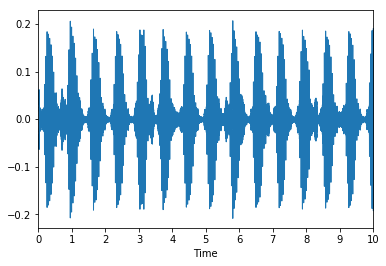

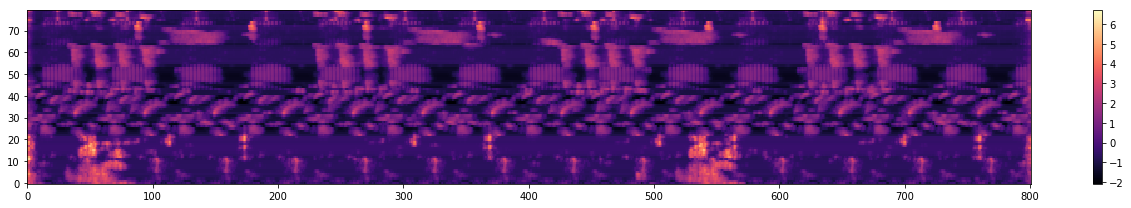

In [21]:
show_audio(wave_aug)

In [ ]:
test_dataset = BaseDataset(root_dir, df, cache= all_audio ,  enable_mixup=False, enable_aug=False)

In [ ]:
y,feat,label = test_dataset.__getitem__(100)
print(label)
show_audio(y)

In [ ]:
len(train_dataset)

In [ ]:
batch_size=2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_dataloader, eval_dataloader= get_dataloaders(train_dataset, test_dataset, batch_size, device)

In [ ]:
td= iter(train_dataloader)

In [ ]:
%%time
x,y = next(td)